<a href="https://colab.research.google.com/github/asbaileyUSD/AAI521_FinalProject/blob/main/FinalProject_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import pathlib
import os
import PIL
import PIL.Image
import cv2
import seaborn as sns
import zipfile
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.__version__

'2.9.2'

## Load the data

In [ ]:
# Extract zip file of dataset saved in your google drive to colab runtime instance ('%%capture' hides long output log)
%%capture
!unzip '/content/drive/MyDrive/AAI_521/FinalProject/Data/Micro_expressions.zip' -d "/content"

In [ ]:
# load dataset
batch_size = 32
data_path = '/content/Micro_Expressions/'

train_ds = tf.keras.utils.image_dataset_from_directory(data_path + '/train/', labels = 'inferred', label_mode = 'int', validation_split=0.2, 
                                                       subset='training', seed = 42, image_size = (80,80), batch_size = batch_size, shuffle = True)
val_ds = tf.keras.utils.image_dataset_from_directory(data_path + '/train/', labels = 'inferred', label_mode = 'int', validation_split = 0.2, 
                                                     subset= 'validation', seed = 42, image_size = (80,80), batch_size = batch_size, shuffle = True)
test_ds = tf.keras.utils.image_dataset_from_directory(data_path + '/test/', labels = 'inferred', label_mode = 'int', image_size = (80,80), shuffle = False)

Found 7600 files belonging to 7 classes.
Using 6080 files for training.
Found 7600 files belonging to 7 classes.
Using 1520 files for validation.
Found 1860 files belonging to 7 classes.


## Exploratory Data Analysis

In [ ]:
# View classes
train_classes = train_ds.class_names
test_classes = test_ds.class_names
print(train_classes)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [ ]:
# Extract labels and respective counts from the training dataset to allow visualization
labels_train = np.concatenate([y for _, y in train_ds], axis = 0)
_, counts = np.unique(labels_train, return_counts = True)
print(labels_train)

labels_test = np.concatenate([y for _, y in test_ds], axis = 0)
print(labels_test)
print(np.unique(labels_test, return_counts = True))

[5 4 3 ... 6 3 5]
[0 0 0 ... 6 6 6]
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([350, 160, 120, 480, 160, 330, 260]))


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


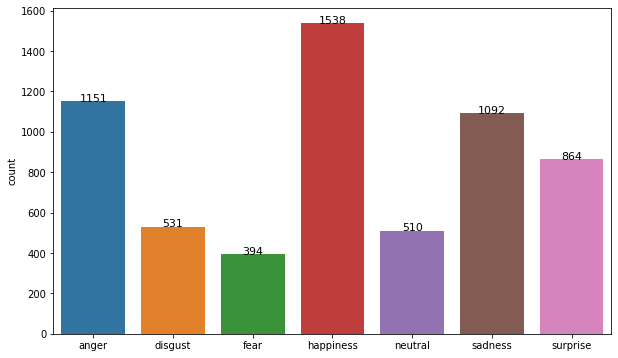

In [ ]:
# Visualize class distribution in training data
plt.figure(figsize=(10, 6))
ax = sns.countplot(labels_train, x = train_classes)
ax.set_xticklabels(train_classes)
for rect in ax.patches:
  ax.text(rect.get_x() + rect.get_width() / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
ax

<function matplotlib.pyplot.show(*args, **kw)>

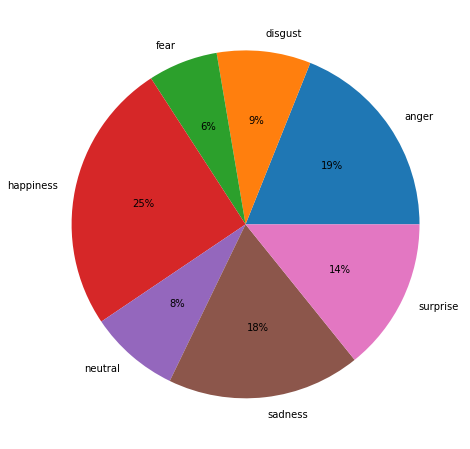

In [ ]:
colors = sns.color_palette('pastel')[0:5]
# create pie chart
plt.figure(figsize=(8, 8))
plt.pie(x = counts, labels = train_classes, autopct = '%.0f%%')
plt.show

In [ ]:
from sklearn.utils import class_weight

# Balance the training dataset

# We will feed this into the 'fit' method when initializing training
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(labels_train), 
                                                  y = labels_train)
# convert to dictionary as required by the class_weight variable in 'fit' method
weights_dict = {i:w for i,w in enumerate(class_weights)}
weights_dict

{0: 0.754623308923917,
 1: 1.6357277374226527,
 2: 2.2044960116026107,
 3: 0.5647408508266766,
 4: 1.7030812324929971,
 5: 0.7953950811093669,
 6: 1.0052910052910053}

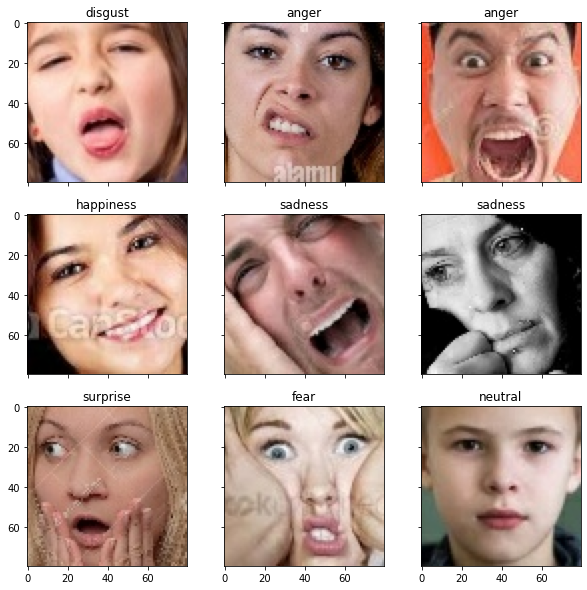

In [ ]:
# Visualize some of the images in the first batch
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in train_ds.take(1):
  for i in range(3):
    for j in range(3):
      ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
      ax[i][j].set_title(train_ds.class_names[labels[i*3+j]])
plt.show()

## Preprocessing and Augmentation

In [ ]:
# Rescale and other augmentations
preprocessing = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
])

# Augmentations
augment = tf.keras.Sequential([
    tf.keras.Input(shape = (80,80,3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    #layers.experimental.preprocessing.RandomWidth(factor=0.15),
    #layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

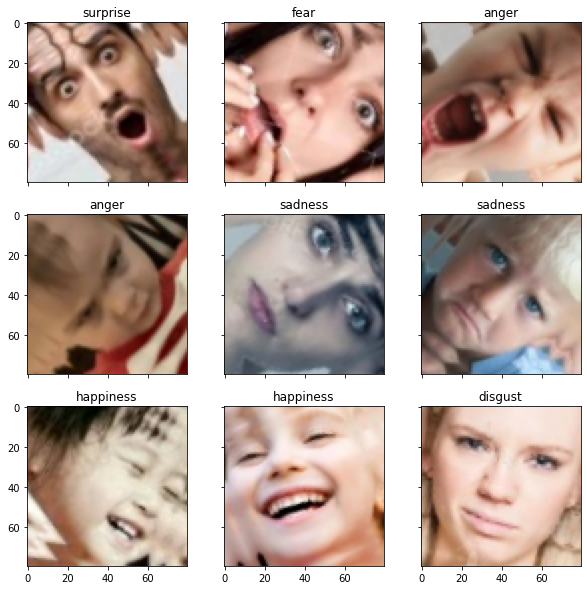

In [ ]:
# Visualize augmented images
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in train_ds.take(1):
  image = preprocessing(images)
  image = augment(images)
  for i in range(3):
    for j in range(3):
      ax[i][j].imshow(image[i*3+j].numpy().astype("uint8"))
      ax[i][j].set_title(train_ds.class_names[labels[i*3+j]])
plt.show()

## Model Selection

In [ ]:
# Define CNN Architecture
model = tf.keras.Sequential([
    tf.keras.Input(shape = (80,80,3)),
    preprocessing,
    augment,
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train_classes), activation = 'softmax')])

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
# # cache data in memory for training
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds_new = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds_new = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# # Reference: https://developer.habana.ai/tutorials/tensorflow/image-classification/

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 80, 80, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 80, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 64)       256       
 ormalization)                                        

In [ ]:
# define learning rate reduction on plateau and early stopping callbacks
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.75, patience = 2, verbose = 1)
e_stop = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience = 6, verbose = 1, restore_best_weights = True )

# # Create callback for saving model checkpoints
# checkPoint_Path = '/content/drive/MyDrive/AAI_521/FinalProject/TrainingCheckpoints/Model1'
# checkPoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkPoint_Path,  
#                                                 monitor = 'val_accuracy', 
#                                                 mode = 'max',
#                                                 save_freq = 10 * batch_size)

In [ ]:
# train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=60, class_weight = weights_dict, batch_size = 32, callbacks = [rlp, e_stop])

Epoch 1/60


190/190 [==============================] - 44s 178ms/step - loss: 2.4932 - accuracy: 0.2038 - val_loss: 1.8766 - val_accuracy: 0.2421 - lr: 0.0010
Epoch 2/60
190/190 [==============================] - 33s 174ms/step - loss: 1.8398 - accuracy: 0.2722 - val_loss: 1.8353 - val_accuracy: 0.2539 - lr: 0.0010
Epoch 3/60
190/190 [==============================] - 32s 168ms/step - loss: 1.7483 - accuracy: 0.3204 - val_loss: 1.7336 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 4/60
190/190 [==============================] - 32s 169ms/step - loss: 1.6856 - accuracy: 0.3459 - val_loss: 1.5562 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 5/60
190/190 [==============================] - 35s 181ms/step - loss: 1.6514 - accuracy: 0.3664 - val_loss: 1.5195 - val_accuracy: 0.4257 - lr: 0.0010
Epoch 6/60
190/190 [==============================] - 33s 173ms/step - loss: 1.5833 - accuracy: 0.3965 - val_loss: 1.6593 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 7/60
190/190 [==============================] - 32s 166ms

In [ ]:
# Save the model
!mkdir -p saved_model
model.save('/content/drive/MyDrive/AAI_521/FinalProject/SavedModels/my_model')

In [ ]:
# Save model as hdf5
model.save('/content/drive/MyDrive/AAI_521/FinalProject/SavedModels/my_model1.h5') 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Function to plot the learning curve
def learning_curve(hist):
  plt.subplot(2,1,1)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Accuracy Curve')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'lower right')

  plt.subplot(2,1,2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Loss Curve')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'upper right')

  plt.subplots_adjust(top = 2.5, bottom = 0.5)
  return plt.show

# Function to evaluate the model on the test data
def evaluation(testData, trainedModel):
  y_true = []
  y_pred = []
  errors=0
  count=0
  # list of class names associated with each image file in test dataset 
  for images, label in testData:   
      for i in label:
          y_true.append(test_classes[i]) 
  preds = trainedModel.predict(testData, verbose=1) # predict on the test data
  
  # get index of prediction with highest probability
  for i, p in enumerate(preds):
    count += 1
    index = np.argmax(p) 
    class_ = test_classes[index] 
    y_pred.append(class_)  
    if class_ != y_true[i]:
        errors +=1

  acc = (count - errors) * 100 / count
  msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
  print(msg) 
  y_pred=np.array(y_pred)
  y_true=np.array(y_true)
  
  # create confusion matrix 
  cm = confusion_matrix(y_true, y_pred)        
  length=len(test_classes)
  fig_width= int(length * .5)
  fig_height= int(length * .5)
  plt.figure(figsize=(fig_width, fig_height))
  sns.set_style('darkgrid')
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
  plt.xticks(np.arange(length)+.5, test_classes, rotation= 90)
  plt.yticks(np.arange(length)+.5, test_classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  clr = classification_report(y_true, y_pred, target_names = test_classes)
  print("Classification Report:\n----------------------\n", clr)

# Reference: https://stackoverflow.com/questions/69933885/find-confusion-matrix-of-image-classification-in-tensorflow

<function matplotlib.pyplot.show(*args, **kw)>

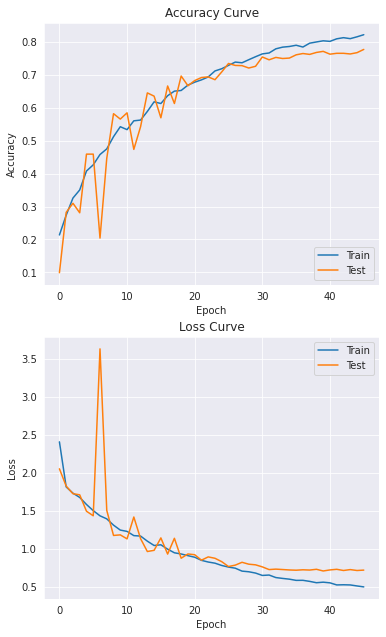

In [ ]:
learning_curve(history)

59/59 [==============================] - 2s 26ms/step
there were 1438 correct predictions in 1860 tests for an accuracy of  77.31 % 


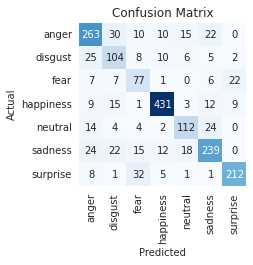

Classification Report:
----------------------
               precision    recall  f1-score   support

       anger       0.75      0.75      0.75       350
     disgust       0.57      0.65      0.61       160
        fear       0.52      0.64      0.58       120
   happiness       0.92      0.90      0.91       480
     neutral       0.72      0.70      0.71       160
     sadness       0.77      0.72      0.75       330
    surprise       0.87      0.82      0.84       260

    accuracy                           0.77      1860
   macro avg       0.73      0.74      0.73      1860
weighted avg       0.78      0.77      0.78      1860



In [ ]:
evaluation(test_ds, model)

## Model 2: Transfer learning with EfficientNetV2B3
Chosen for it's relatively low GPU compute times (see benchmarks of V1 version of the EfficientNet)

Reference: https://keras.io/api/applications/

In [ ]:
# Import the model
from tensorflow.keras.applications import EfficientNetV2B3

In [ ]:
# EfficientNetV2 already includes a preprocessing layer to rescale values to between -1 and 1

# Rescale dataset to -1 and 1
preprocessing_Enet = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)])


Model 2 with all weights frozen in base model:

In [ ]:
input_shape = (80,80,3)
# Instantiate pre-trained model and set 'include_preprocessing' to false because values already rescaled
Enet_model = EfficientNetV2B3(include_top = False, weights = 'imagenet', include_preprocessing = False, input_shape = input_shape)

52606240/52606240 [==============================] - 2s 0us/step


In [ ]:
# define new learning rate reduction on plateau's and early stopping callbacks
rlp_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, verbose = 1)
e_stop_2 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience = 6, verbose = 1, restore_best_weights = True )

In [ ]:
# Freeze weights
Enet_model.trainable = False

# Create new model with pre-trained model
model2 = tf.keras.Sequential([
    tf.keras.Input(shape = input_shape),
    preprocessing_Enet,
    augment,
    Enet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train_classes), activation = 'softmax')])

model2.compile(optimizer='adam', loss ='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
initial_epochs = 60

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 80, 80, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 80, 80, 3)         0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)             

In [ ]:
# # Create callback for saving checkpoints with model weights
# checkPoint_Path = '/content/drive/MyDrive/AAI_521/FinalProject/TrainingCheckpoints/Model2'
# checkPoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkPoint_Path, 
#                                                 save_weights_only = True, 
#                                                 monitor = 'val_accuracy', 
#                                                 mode = 'max', 
#                                                 save_best_only = True, 
#                                                 save_freq = 5 * batch_size)

In [ ]:
# Train second model
history2 = model2.fit(train_ds, validation_data = val_ds, epochs = initial_epochs, class_weight = weights_dict, batch_size = 32, callbacks = [rlp_2, e_stop_2])

Epoch 1/60


190/190 [==============================] - 58s 212ms/step - loss: 1.7231 - accuracy: 0.3388 - val_loss: 1.5801 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/60
190/190 [==============================] - 38s 200ms/step - loss: 1.5832 - accuracy: 0.3959 - val_loss: 1.5724 - val_accuracy: 0.3776 - lr: 0.0010
Epoch 3/60
190/190 [==============================] - 37s 192ms/step - loss: 1.5435 - accuracy: 0.4115 - val_loss: 1.4732 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 4/60
190/190 [==============================] - 37s 193ms/step - loss: 1.5056 - accuracy: 0.4232 - val_loss: 1.5656 - val_accuracy: 0.3941 - lr: 0.0010
Epoch 5/60
190/190 [==============================] - 39s 205ms/step - loss: 1.4883 - accuracy: 0.4260 - val_loss: 1.4834 - val_accuracy: 0.4270 - lr: 0.0010
Epoch 6/60
190/190 [==============================] - 38s 200ms/step - loss: 1.4717 - accuracy: 0.4368 - val_loss: 1.4549 - val_accuracy: 0.4408 - lr: 0.0010
Epoch 7/60
190/190 [==============================] - 36s 191ms

<function matplotlib.pyplot.show(*args, **kw)>

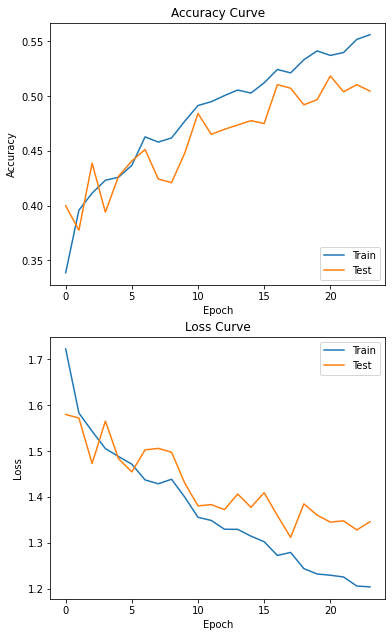

In [ ]:
# Plot learning curve for second model
learning_curve(history2)

59/59 [==============================] - 4s 38ms/step
there were 959 correct predictions in 1860 tests for an accuracy of  51.56 % 


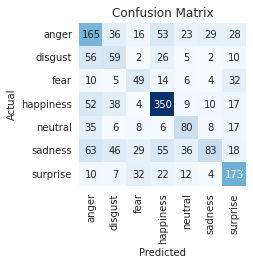

Classification Report:
----------------------
               precision    recall  f1-score   support

       anger       0.42      0.47      0.45       350
     disgust       0.30      0.37      0.33       160
        fear       0.35      0.41      0.38       120
   happiness       0.67      0.73      0.70       480
     neutral       0.47      0.50      0.48       160
     sadness       0.59      0.25      0.35       330
    surprise       0.59      0.67      0.62       260

    accuracy                           0.52      1860
   macro avg       0.48      0.48      0.47      1860
weighted avg       0.53      0.52      0.51      1860



In [ ]:
# Predict and evaluate the model on the test dataset
evaluation(test_ds, model2)

### Model 2b
We now retrain the entire model with all layers unfrozen in the base model (efficientnetV2) since transfer learning did not perform well indicating the original weights did not increase performance on the new dataset.  This means the original dataset used to train the pretrained was not a good fit for our new dataset.

In [ ]:
# Reinstantiate the pretrained model to use as the base model
input_shape = (80,80,3)
Enet_model_2 = EfficientNetV2B3(include_top = False, weights = 'imagenet', include_preprocessing=False, input_shape = input_shape)

In [ ]:
# Ensure model is
Enet_model_2.trainable = True

In [ ]:
# Create new model with base model
model3 = tf.keras.Sequential([
    tf.keras.Input(shape = input_shape),
    preprocessing_Enet,
    augment,
    Enet_model_2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train_classes), activation = 'softmax')])

model3.compile(optimizer='adam', loss ='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 80, 80, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 80, 80, 3)         0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)             

In [ ]:
history3 = model3.fit(train_ds, validation_data = val_ds, epochs = 60, class_weight = weights_dict, batch_size = 32, callbacks = [rlp_2, e_stop_2])

Epoch 1/60


190/190 [==============================] - 64s 238ms/step - loss: 1.6450 - accuracy: 0.3766 - val_loss: 1.5547 - val_accuracy: 0.4263 - lr: 0.0010
Epoch 2/60
190/190 [==============================] - 44s 230ms/step - loss: 1.3648 - accuracy: 0.5135 - val_loss: 1.2576 - val_accuracy: 0.5428 - lr: 0.0010
Epoch 3/60
190/190 [==============================] - 43s 224ms/step - loss: 1.2773 - accuracy: 0.5492 - val_loss: 1.4491 - val_accuracy: 0.4842 - lr: 0.0010
Epoch 4/60
190/190 [==============================] - 42s 221ms/step - loss: 1.1827 - accuracy: 0.5859 - val_loss: 1.5397 - val_accuracy: 0.4178 - lr: 0.0010
Epoch 5/60
190/190 [==============================] - 43s 224ms/step - loss: 1.0882 - accuracy: 0.6235 - val_loss: 1.1499 - val_accuracy: 0.5829 - lr: 0.0010
Epoch 6/60
190/190 [==============================] - 42s 221ms/step - loss: 1.0475 - accuracy: 0.6431 - val_loss: 1.1815 - val_accuracy: 0.6033 - lr: 0.0010
Epoch 7/60
190/190 [==============================] - 42s 222ms

<function matplotlib.pyplot.show(*args, **kw)>

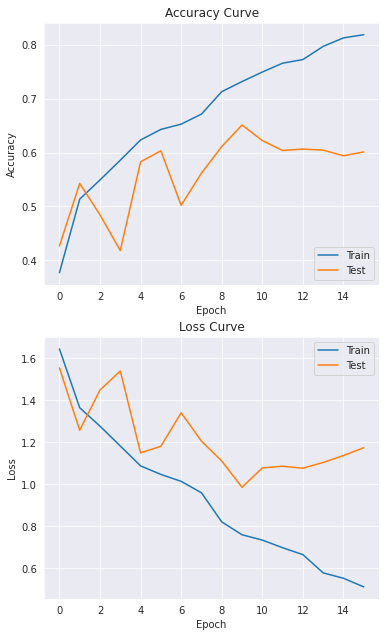

In [ ]:
learning_curve(history3)

59/59 [==============================] - 4s 31ms/step
there were 1192 correct predictions in 1860 tests for an accuracy of  64.09 % 


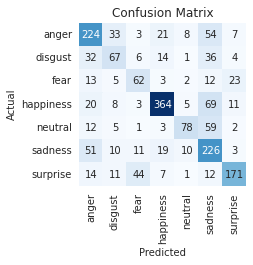

Classification Report:
----------------------
               precision    recall  f1-score   support

       anger       0.61      0.64      0.63       350
     disgust       0.48      0.42      0.45       160
        fear       0.48      0.52      0.50       120
   happiness       0.84      0.76      0.80       480
     neutral       0.74      0.49      0.59       160
     sadness       0.48      0.68      0.57       330
    surprise       0.77      0.66      0.71       260

    accuracy                           0.64      1860
   macro avg       0.63      0.59      0.61      1860
weighted avg       0.66      0.64      0.65      1860



In [ ]:
evaluation(test_ds, model3)